# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [1]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdBwdLoss, EMLoss
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling


# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
Data = Data_handling(
    dataset='iris',
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y

df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df


,feature_0,feature_1,feature_2,feature_3,target
0,5.0,3.4,1.6,0.4,"[1.0, 0.0, 0.0]"
1,6.3,3.3,4.7,1.6,"[0.0, 1.0, 0.0]"
2,5.1,3.4,1.5,0.2,"[1.0, 0.0, 0.0]"
3,4.8,3.0,1.4,0.1,"[1.0, 0.0, 0.0]"
4,6.7,3.1,4.7,1.5,"[0.0, 1.0, 0.0]"
...,...,...,...,...,...
115,5.5,4.2,1.4,0.2,"[1.0, 0.0, 0.0]"
116,6.8,3.0,5.5,2.1,"[0.0, 0.0, 1.0]"
117,5.1,3.8,1.5,0.3,"[1.0, 0.0, 0.0]"
118,6.0,2.7,5.1,1.6,"[0.0, 1.0, 0.0]"


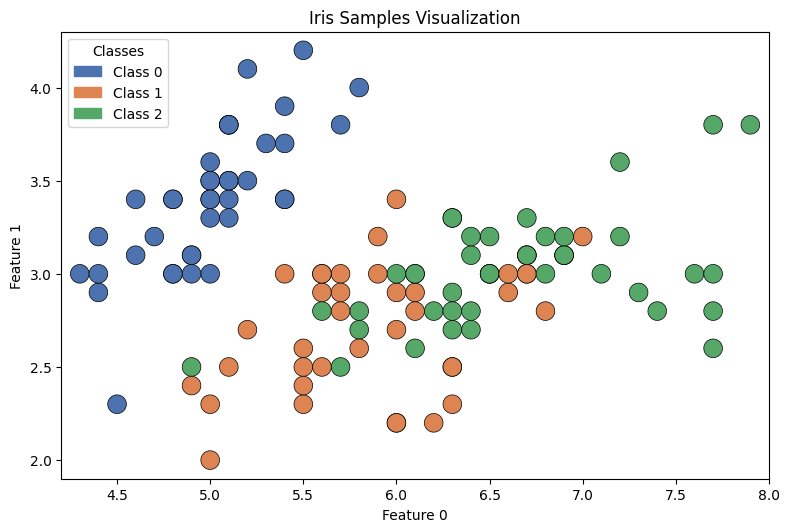

In [4]:
visualize_dataset(
    df,
    features=['feature_0', 'feature_1'],
    classes=3,
    title='Iris Samples Visualization',
)


Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [5]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
#weakener.generate_M(model_class='unif_noise', corr_p=0.2) #Try this for noisy labels
print(f"Generated M matrix:\n{weakener.M}")
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z, w = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")
print(f"Generated w (multi-label matrix):\n{w}")

Data.include_weak(z)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')

batch = next(iter(train_loader))
xb, wb, yb = batch
print(f"Inputs batch shape: {xb.shape}")
print(f"Weak (partial) labels shape: {wb.shape}")
print(f"True one-hot labels shape: {yb.shape}")

Generated M matrix:
[[0.   0.   0.64]
 [0.   0.64 0.  ]
 [0.   0.16 0.16]
 [0.64 0.   0.  ]
 [0.16 0.   0.16]
 [0.16 0.16 0.  ]
 [0.04 0.04 0.04]]
Generated z (noisy labels):
tensor([3, 5, 4, 3, 1, 0, 0, 4, 1, 2, 0, 6, 4, 0, 0, 3, 0, 0, 1, 1, 3, 3, 1, 1,
        1, 2, 3, 0, 3, 0, 1, 0, 0, 4, 6, 5, 1, 0, 2, 3, 0, 3, 1, 5, 3, 2, 1, 3,
        3, 0, 6, 2, 4, 4, 1, 5, 3, 0, 3, 0, 0, 1, 5, 3, 1, 1, 1, 5, 1, 6, 2, 1,
        3, 4, 2, 2, 2, 3, 0, 3, 4, 0, 1, 0, 0, 0, 4, 3, 5, 1, 0, 2, 4, 1, 2, 3,
        0, 3, 0, 3, 3, 1, 3, 1, 5, 1, 0, 2, 0, 1, 3, 1, 5, 4, 3, 5, 4, 3, 5, 3],
       dtype=torch.int32)
Generated w (multi-label matrix):
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 0., 1.],
        [1., 1., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0.,

In [6]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]
df

,feature_0,feature_1,feature_2,feature_3,target
0,5.0,3.4,1.6,0.4,"[1.0, 0.0, 0.0]"
1,6.3,3.3,4.7,1.6,"[1.0, 1.0, 0.0]"
2,5.1,3.4,1.5,0.2,"[1.0, 0.0, 1.0]"
3,4.8,3.0,1.4,0.1,"[1.0, 0.0, 0.0]"
4,6.7,3.1,4.7,1.5,"[0.0, 1.0, 0.0]"
...,...,...,...,...,...
115,5.5,4.2,1.4,0.2,"[1.0, 1.0, 0.0]"
116,6.8,3.0,5.5,2.1,"[1.0, 0.0, 1.0]"
117,5.1,3.8,1.5,0.3,"[1.0, 0.0, 0.0]"
118,6.0,2.7,5.1,1.6,"[1.0, 1.0, 0.0]"


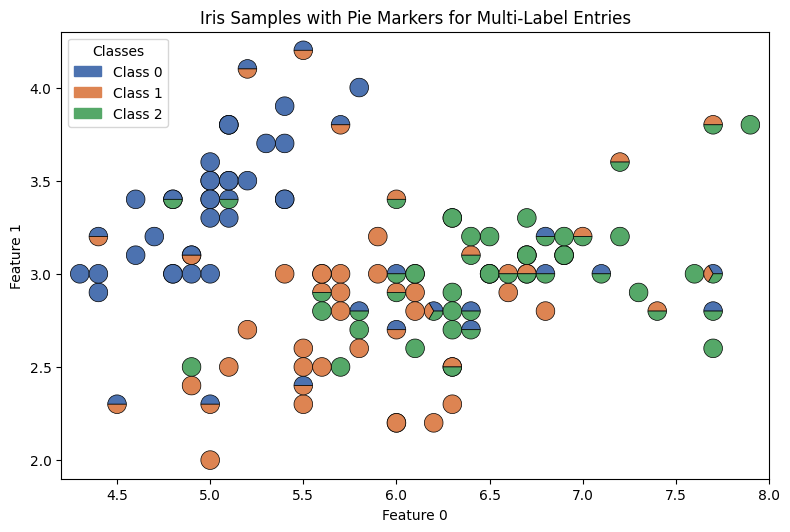

In [7]:
visualize_dataset(
    df,
    features=['feature_0', 'feature_1'],
    classes=3,
    title='Iris Samples with Pie Markers for Multi-Label Entries'
)



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='id'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=5e-2,
)

#pll_loss = EMLoss(weakener.M)
pll_loss = FwdBwdLoss(B=np.eye(weakener.d), F=weakener.M)


Using device: cpu


## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

In [9]:
# 2. Training parameters
num_epochs = 30


# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    pll_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)


Epoch 10/30: Train Loss: 1.3351, Train Acc: 0.6750, Test Acc: 0.6333, Train Detached Loss: 0.0081, Test Detached Loss: 0.0162, Learning Rate: 0.050000, Epoch Time: 0.00 seconds
Epoch 20/30: Train Loss: 1.2350, Train Acc: 0.9167, Test Acc: 1.0000, Train Detached Loss: 0.0060, Test Detached Loss: 0.0109, Learning Rate: 0.050000, Epoch Time: 0.00 seconds
Epoch 30/30: Train Loss: 1.1835, Train Acc: 0.9500, Test Acc: 1.0000, Train Detached Loss: 0.0049, Test Detached Loss: 0.0084, Learning Rate: 0.050000, Epoch Time: 0.00 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0       1    1.846551   0.291667  0.266667             0.016798   
1       2    1.689604   0.508333  0.733333             0.014965   
2       3    1.639057   0.650000  0.800000             0.012948   
3       4    1.546046   0.600000  0.633333             0.011782   
4       5    1.489844   0.675000  0.633333             0.011097   
5       6    1.444426   0.675000  0.633333             0.009728   


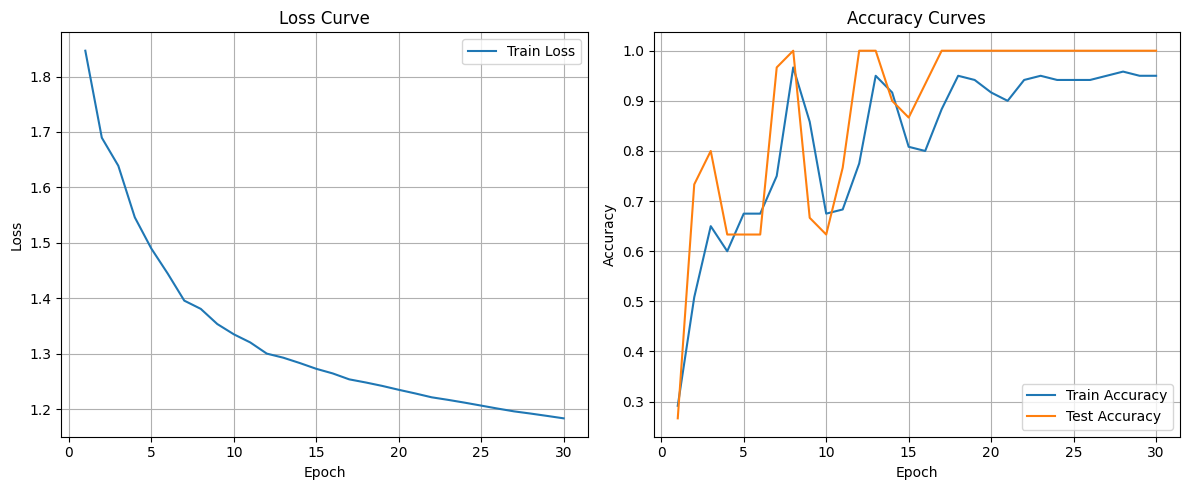

In [10]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [11]:
clean_indices = Data.train_dataset.targets.argmax(dim=1)  


Data.include_weak(clean_indices)

train_loader, test_loader = Data.get_dataloader(weak_labels='weak')


clean_loss =  FwdBwdLoss(np.eye(weakener.c), np.eye(weakener.c)) 


model_clean = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='id'
)

optimizer_clean = optim.Adam(
    model_clean.parameters(),
    lr=5e-2,
)


num_epochs = 30
model_clean, clean_results = train_and_evaluate(
    model_clean,     
    train_loader,    
    test_loader,     
    optimizer_clean, 
    clean_loss,      
    num_epochs,
    corr_p=0           
)


print(clean_results)


Epoch 10/30: Train Loss: 0.5138, Train Acc: 0.8750, Test Acc: 0.7000, Train Detached Loss: 0.0082, Test Detached Loss: 0.0161, Learning Rate: 0.050000, Epoch Time: 0.01 seconds
Epoch 20/30: Train Loss: 0.3889, Train Acc: 0.9667, Test Acc: 1.0000, Train Detached Loss: 0.0064, Test Detached Loss: 0.0115, Learning Rate: 0.050000, Epoch Time: 0.01 seconds
Epoch 30/30: Train Loss: 0.3267, Train Acc: 0.9583, Test Acc: 1.0000, Train Detached Loss: 0.0054, Test Detached Loss: 0.0093, Learning Rate: 0.050000, Epoch Time: 0.01 seconds
    epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0       1    1.193304   0.291667  0.266667             0.017217   
1       2    0.958315   0.483333  0.733333             0.015255   
2       3    0.893727   0.650000  0.733333             0.013606   
3       4    0.800611   0.725000  0.633333             0.011871   
4       5    0.712869   0.675000  0.633333             0.011224   
5       6    0.659625   0.675000  0.633333             0.010226   


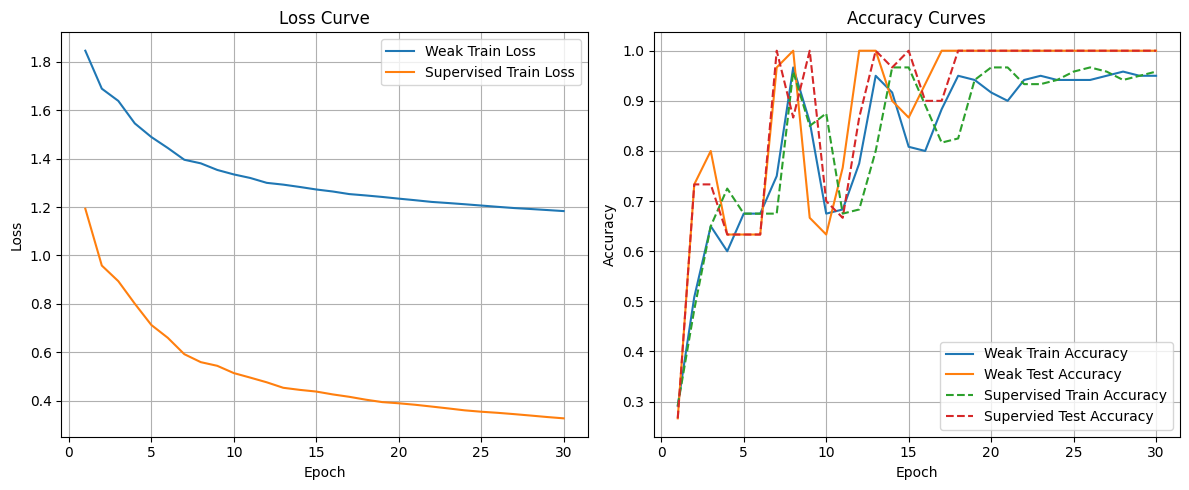

In [12]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()